## Experimenting K-means reliability

In [1]:
# installing feather library, if not yet available
if (!("feather" %in% rownames(installed.packages()))) {
    install.packages("feather")
}

In [2]:
# installing RCurl library, if not yet available
if (!("RCurl" %in% rownames(installed.packages()))) {
    install.packages("RCurl")
}

In [3]:
library(feather)
library(RCurl)

url <- "https://github.com/lmassaron/datasets/releases/download/1.0/penguins.feather"
destfile <- "penguins.feather"
download.file(url, destfile, mode =  "wb")

penguins <- read_feather(destfile)

After downloading the penguins dataset, as a first step we separate the labels (three species of penguins) from the features. For our example we take only the four numeric features.

In [4]:
labels <- as.factor(penguins$species)
features <- as.data.frame(penguins[,2:(ncol(penguins)-1)])

In [5]:
summary(features)

 culmen_length_mm culmen_depth_mm flipper_length_mm  body_mass_g  
 Min.   :32.10    Min.   :13.10   Min.   :172       Min.   :2700  
 1st Qu.:39.50    1st Qu.:15.60   1st Qu.:190       1st Qu.:3550  
 Median :44.50    Median :17.30   Median :197       Median :4050  
 Mean   :43.99    Mean   :17.16   Mean   :201       Mean   :4207  
 3rd Qu.:48.60    3rd Qu.:18.70   3rd Qu.:213       3rd Qu.:4775  
 Max.   :59.60    Max.   :21.50   Max.   :231       Max.   :6300  

Size and mass should be somehow correlated, thus, we take a PCA and separate the various information in components that are uncorrelated among them. That is perfect for doing cluster analysis because we do not risk to evaluate the same information spread in multiple variables.

In [6]:
pca <- prcomp(features, center=TRUE, scale=TRUE)
features.pca <- pca$x

As expected there is one strong component accounting for almost 70% of the information. Still the second and third components seem important anc could help discriminating subtle differences between the species. We don't interpret the PCA results, because we don't need to in order to have our cluster analysis work, but understanding what is inside each component could help you make your mind about what you are really measuring in your analysis (try: pca$rotation). 

Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.6569 0.8821 0.60716 0.32846
Proportion of Variance 0.6863 0.1945 0.09216 0.02697
Cumulative Proportion  0.6863 0.8809 0.97303 1.00000

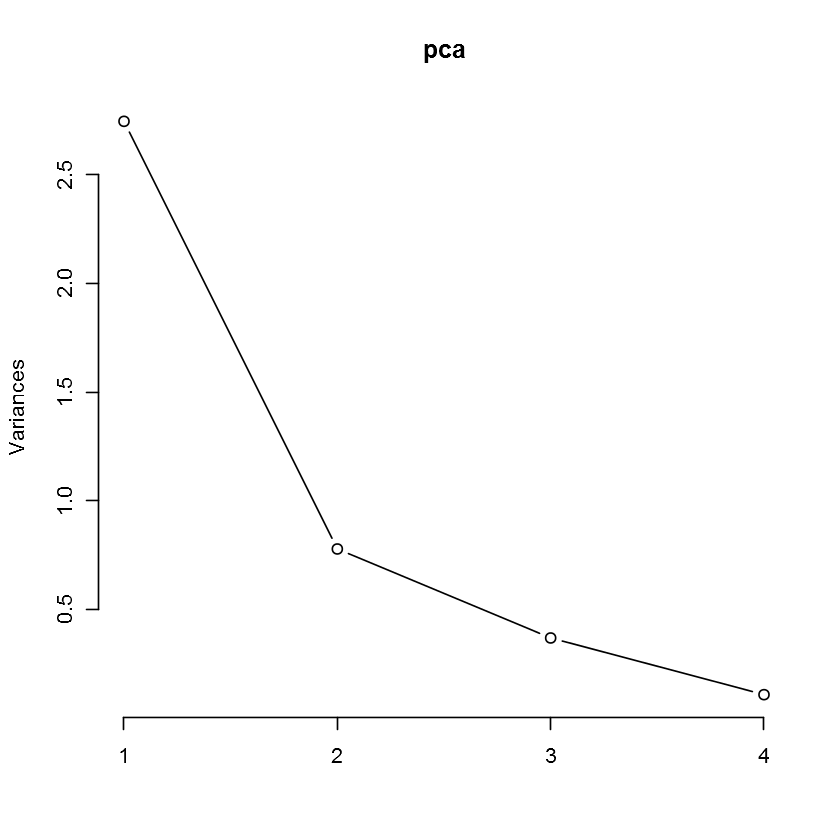

In [7]:
summary(pca)
plot(pca, type="line")

In [8]:
summary(features.pca)

      PC1               PC2                PC3                PC4           
 Min.   :-2.7101   Min.   :-2.59880   Min.   :-2.21730   Min.   :-0.822693  
 1st Qu.:-1.5235   1st Qu.:-0.50099   1st Qu.:-0.40603   1st Qu.:-0.236249  
 Median :-0.5105   Median : 0.01588   Median : 0.03488   Median :-0.004999  
 Mean   : 0.0000   Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.000000  
 3rd Qu.: 1.6101   3rd Qu.: 0.63282   3rd Qu.: 0.38813   3rd Qu.: 0.181760  
 Max.   : 3.7813   Max.   : 2.09359   Max.   : 2.04622   Max.   : 1.066091  

In [9]:
# installing ClusterR library, if not yet available
if (!("ClusterR" %in% rownames(installed.packages()))) {
    install.packages("ClusterR")
}

ClusterR is the most complete clustering library in R, analogous to Scikit-learn clustering module: https://github.com/mlampros/ClusterR. Based on 'Armadillo', a C++ linear algebra library, the functions are very similar to Scikit-learn ones.

In [10]:
library(ClusterR)

k_means <- KMeans_rcpp(features.pca, clusters=3, num_init=10, max_iter=999, 
                       initializer = "kmeans++", seed=101)

mb_k_means <- MiniBatchKmeans(features.pca, clusters=3, num_init=10, max_iter=999,
                              batch_size=30, initializer = "kmeans++", seed=101)

Loading required package: gtools



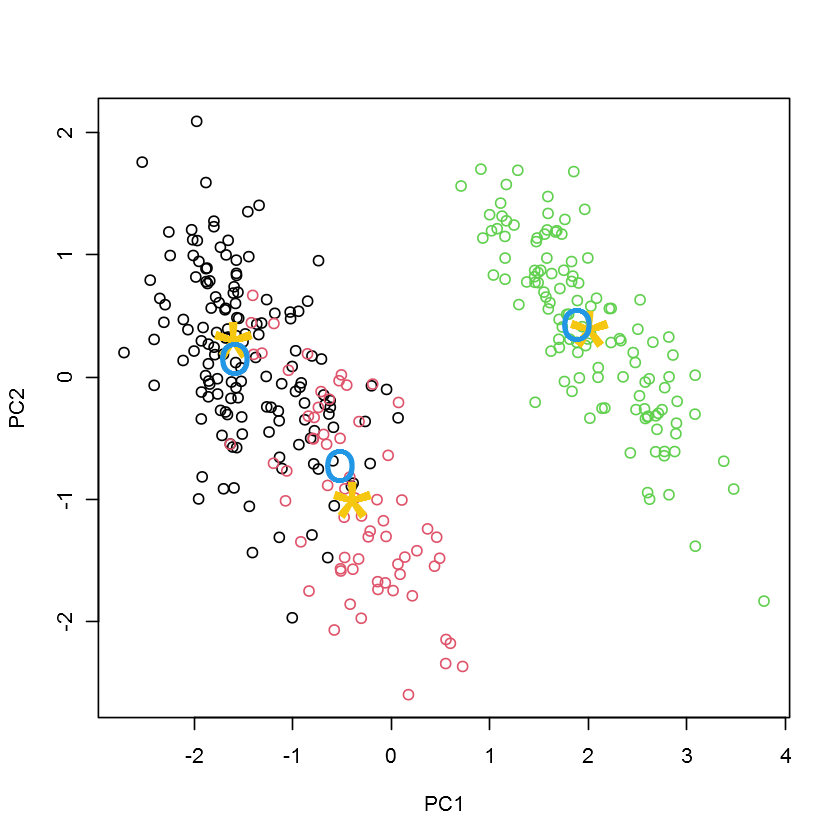

In [11]:
plot(features.pca, col=labels, pch=1)
points(k_means$centroids, col=7, pch="*", cex=6)
points(mb_k_means$centroids, col=4, pch="o", cex=3)

## Experimenting how centroids converge

In [12]:
for (maxiter in 1:9) {
    k_means <- KMeans_rcpp(features.pca, clusters=3, num_init=1, max_iter=maxiter, 
                       initializer = "kmeans++", seed=101)
    clus <- as.data.frame(k_means$centroids)
    cat("iteration:", maxiter, "\n")
    print(clus)
    cat("\n")
}

iteration: 1 
         V1         V2         V3           V4
1 -1.514119  0.1160154  0.4444927 -0.017126137
2 -1.555938  0.5950460 -0.4243772  0.072742946
3  1.118247 -0.1575524 -0.1951888 -0.000996969

iteration: 2 
         V1          V2         V3           V4
1 -1.304732 -0.23859038  0.5184255  0.009400142
2 -1.473468  0.46985722 -0.4131660  0.027175792
3  1.488781 -0.06968117 -0.1296865 -0.018385142

iteration: 3 
         V1         V2          V3           V4
1 -1.062405 -0.5378715  0.35701346  0.009380920
2 -1.470071  0.4278345 -0.34068116 -0.007306145
3  1.770048  0.1232297 -0.04440155 -0.002251859

iteration: 4 
          V1         V2          V3           V4
1 -0.7188159 -0.8246629  0.10800009 -0.010016255
2 -1.5898119  0.4983881 -0.17132496  0.004321573
3  2.0099513  0.3934358  0.03581374  0.006204802

iteration: 5 
         V1         V2          V3           V4
1 -0.578835 -0.8815024 -0.06440227 -0.009931594
2 -1.687619  0.4821770  0.02713860  0.003404845
3  2.009951  0

In [13]:
library(ClusterR)

k_means <- KMeans_rcpp(features.pca, clusters=3, num_init=10, max_iter=999, 
                       initializer = "kmeans++", seed=101)

In [14]:
# installing MLmetrics library, if not yet available
if (!("MLmetrics" %in% rownames(installed.packages()))) {
    install.packages("MLmetrics")
}

MLmetrics is a complete collection of evaluation metrics: https://github.com/yanyachen/MLmetrics

In [15]:
library(MLmetrics)
print(ConfusionMatrix(y_pred=k_means$clusters, y_true=labels))


Attaching package: 'MLmetrics'


The following object is masked from 'package:base':

    Recall




           y_pred
y_true        1   2   3
  Adelie     22 124   0
  Chinstrap  63   5   0
  Gentoo      0   0 119


In [16]:
# installing fpc library, if not yet available
if (!("fpc" %in% rownames(installed.packages()))) {
    install.packages("fpc")
}

Instead we have to use fcp in order to get a function for Calinski-Harabasz Index: https://www.rdocumentation.org/packages/fpc/versions/2.2-6/topics/calinhara

In [17]:
library(fpc)

max_clus <- 20
scores <- NULL

for (clusters in 2:max_clus) {
    k_means <- KMeans_rcpp(features.pca, clusters=clusters, num_init=10, max_iter=999, 
                       initializer = "kmeans++", seed=101)
    score <- calinhara(features.pca, clustering=k_means$clusters)
    scores <- c(scores, score)
}

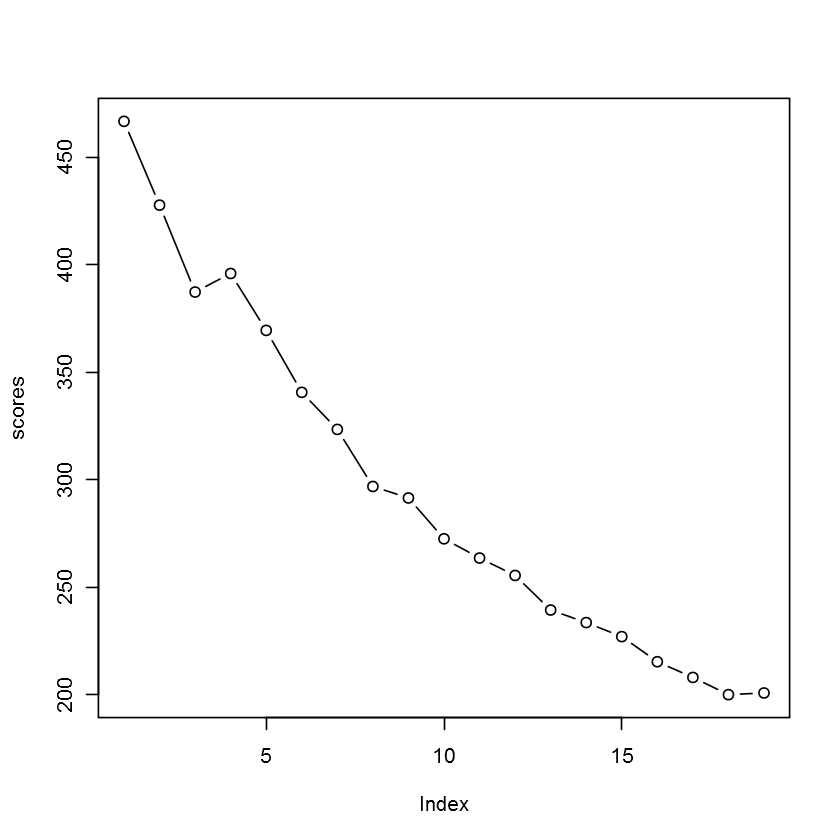

In [18]:
plot(scores, type='b')

In [19]:
k_means <- KMeans_rcpp(features.pca, clusters=5, num_init=10, max_iter=999, 
                   initializer = "kmeans++", seed=101)
print(ConfusionMatrix(y_pred=k_means$clusters, y_true=labels))

           y_pred
y_true       1  2  3  4  5
  Adelie     2  0 84  0 60
  Chinstrap 62  0  6  0  0
  Gentoo     0 57  0 62  0


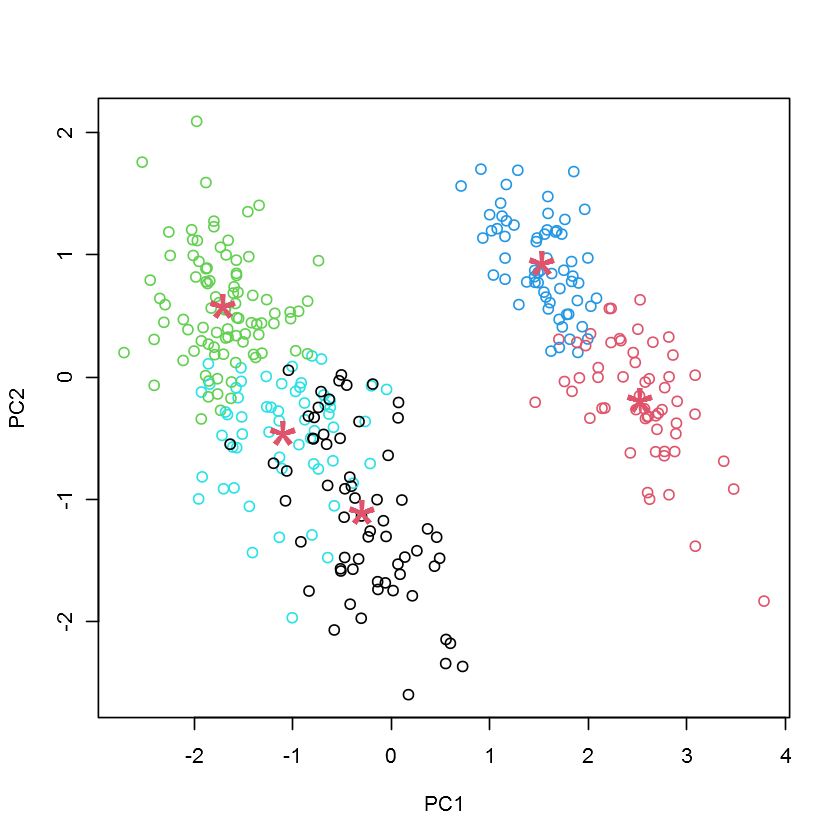

In [20]:
plot(features.pca, col=k_means$clusters, pch=1)
points(k_means$centroids, col=2, pch="*", cex=4)

## Experimenting with a flexible algorithm

In [21]:
# installing caret library, if not yet available
if (!("caret" %in% rownames(installed.packages()))) {
    install.packages("caret")
}

This time we use the caret library in order to automatically tune a knn model using cross validation. Wsing the trainControl command we determinate the type of validation and its specific parameters. The method of the train functions allow us flexibly to decide what algorithm to run by just specifying it in a string. Finally the tuneLength points out how many combinations of key parameters we can test in order to optimize the training.

In [22]:
library(caret)
set.seed(42)

trctrl <- trainControl(method="repeatedcv", number=10, repeats=3)

plain_features <- cbind(features, labels)
knn_fit <- train(labels ~ ., data=plain_features, method = "knn",
                 trControl=trctrl, tuneLength = 10)

print(knn_fit)

Loading required package: lattice

Loading required package: ggplot2


Attaching package: 'caret'


The following objects are masked from 'package:MLmetrics':

    MAE, RMSE




k-Nearest Neighbors 

333 samples
  4 predictor
  3 classes: 'Adelie', 'Chinstrap', 'Gentoo' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 300, 299, 300, 299, 300, 301, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.7887682  0.6599740
   7  0.7665664  0.6180774
   9  0.7746769  0.6290285
  11  0.7887719  0.6519772
  13  0.7636865  0.6102072
  15  0.7606581  0.6029519
  17  0.7609589  0.6025143
  19  0.7577726  0.5964344
  21  0.7548927  0.5909494
  23  0.7366997  0.5584452

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 11.


After running, we have a complete reporting of the parameter combinations run. In this case we only tested for different k parameters and the best result, based on the accuracy metric, has been k=11.

We now replicate the same process but this time, instead of the original data, we will use the data processed by PCA.

In [23]:
pca_features <- cbind(as.data.frame(features.pca), labels)

knn_fit <- train(labels ~ ., data=pca_features, method = "knn",
                 trControl=trctrl, tuneLength = 10)

print(knn_fit)

k-Nearest Neighbors 

333 samples
  4 predictor
  3 classes: 'Adelie', 'Chinstrap', 'Gentoo' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 301, 300, 299, 299, 300, 301, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.9839219  0.9746318
   7  0.9840742  0.9745791
   9  0.9841058  0.9746929
  11  0.9810439  0.9698192
  13  0.9790218  0.9666283
  15  0.9810123  0.9697477
  17  0.9789903  0.9665912
  19  0.9779505  0.9649582
  21  0.9789903  0.9665912
  23  0.9769385  0.9633361

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 9.


In [24]:
# installing reticulate library, if not yet available
if (!("reticulate" %in% rownames(installed.packages()))) {
    install.packages("reticulate")
}

For this last example we need to replicate the results obtained from Scikit-learn dataset functions. As explained here: https://github.com/rstudio/reticulate , reticulate is a package that can run Python for you in background and get the results into R.

In [ ]:
library(reticulate)

sklearn <- import("sklearn")
np <- import("numpy")

In [26]:
strange_data <- sklearn$datasets$make_circles(n_samples=500L, shuffle=TRUE, 
                                              noise=0.15, random_state=101L, factor=0.5)
strange_data <- as.data.frame(strange_data)[,1:2]

dist <- strange_data$X1**2 + strange_data$X2**2
strange_data <- strange_data[order(dist),]

center <-  sklearn$datasets$make_blobs(n_samples=100L, n_features=2L, centers=1L, 
                                       cluster_std=0.1, center_box=c(0, 0))

center <- as.data.frame(center)[,1:2]

In [27]:
data <- rbind(strange_data, center)
labels = as.factor(c(rep("inner_ring", 250), rep("center_outside", 350)))

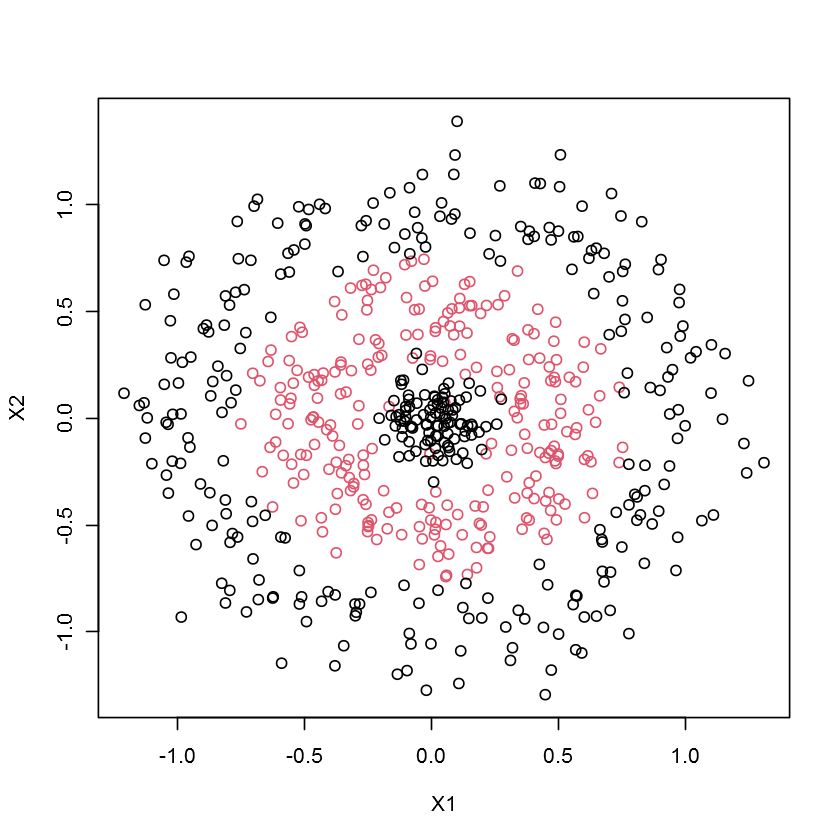

In [28]:
plot(data, col=labels, pch=1)

In [29]:
dataset <- cbind(as.data.frame(data), labels)

knn_fit <- train(labels ~ ., data=dataset, method = "knn",
                 trControl=trctrl, tuneLength = 10)

print(knn_fit)

k-Nearest Neighbors 

600 samples
  2 predictor
  2 classes: 'center_outside', 'inner_ring' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 540, 540, 540, 540, 540, 540, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.9555556  0.9083616
   7  0.9600000  0.9175996
   9  0.9666667  0.9312510
  11  0.9666667  0.9312371
  13  0.9688889  0.9359016
  15  0.9644444  0.9268228
  17  0.9650000  0.9280244
  19  0.9672222  0.9326357
  21  0.9683333  0.9348168
  23  0.9644444  0.9268759

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 13.
